<h2>Análise de Risco de Crédito Bancário: Aplicação de Algoritmos de Machine Learning</h2>

<h4>Por: João Dionísio Cubai</h4>
<h5>e-mail: dionisiocubai@gmail.com</h5>

### Base de Dados 
* **credit_risk_dataset**. Disponível em: https://www.kaggle.com/datasets/laotse/credit-risk-dataset


### Descrição das Variáveis da Base de Dados

* **person_age:** Idade do cliente (anos)
* **person_income:** Renda do cliente (unidades monetárias)
* **person_home_ownership:** Popriedade da residência do cliente (Aluguel, Prórpia, Hipoteca, Outro)
* **person_emp_length:** Tempo de emprego do cliente (anos)
* **loan_intent:** Finalidade do empréstimo
* **loan_grade:** Classe do empréstimo (A, B, C, D, E, F, G) 
* **loan_amnt:** Montante de empréstimo solicitado
* **loan_int_rate:** Taxa de juro sobre o empréstimo (%)
* **loan_status:** Inadimplência (0 = Adimplente, 1=Inadimplente)
* **loan_percent_income:** Parte da renda que está comprometida com o pagamento do empréstimo (%)              
* **cb_person_default_on_file:** Histórico registado de inadimplência do cliente (Sim, Nao)
* **cb_person_cred_hist_length:** Tempo de histórico de crédito do cliente (anos)

### Instalação e Importação de Bibliotecas

In [ ]:
#Instalação das bibliotecas 
# !pip install shap
# !pip install scikit-posthocs

In [42]:
# Iportação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV 
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.stats import ks_2samp, shapiro, levene, friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman
import shap

import warnings
warnings.filterwarnings("ignore")

### Carregamento e Tradução da Base de Dados para Português

In [15]:
# Carregamendo da base de dados original

df_original = pd.read_csv('credit_risk_dataset.csv')
print(f"\n{'='*45} Base de Dados Original {'='*45}")
print(f'\{df_original.info()}')


============================================= Base de Dados Original =============================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  3

In [16]:
# Tradução da base de dados para português

# Renomeamento das colunas
df_pt = df_original.rename(columns={
    'person_age': 'idade', # idade do cliente
    'person_income': 'renda', # Renda anual do cliente
    'person_home_ownership': 'propriedade_residencia', # Propriedade da residência do cliente (Aluguel, prórpia, hipoteca, outro)
    'person_emp_length': 'tempo_emprego', # Tempo de emprego do cliente (anos)
    'loan_intent': 'finalidade_credito', # Finalidade do empréstimo
    'loan_grade': 'nota_credito', # Classe do empréstimo (A, B, C, D, E, F, G) 
    'loan_amnt': 'montante_credito', # Montante de empréstimo solicitado
    'loan_int_rate': 'taxa_juro', # Taxa de juro sobre o empréstimo (%)
    'loan_status': 'inadimplencia', # Inadimplência (0 = Adimplente, 1=Inadimplente)
    'loan_percent_income': 'percent_renda_comprometida', # Parte da renda que está comprometida com o pagamento do empréstimo (%)              
    'cb_person_default_on_file': 'historico_inadimplencia', # Histórico registado de inadimplência do cliente (Sim, Nao)
    'cb_person_cred_hist_length': 'tempo_historico_credito', # tempo (anos) de histórico de crédito do cliente
})

# Renomeamento dos valores de algumas variáveis ('propriedade_residencial', 'intencao_emprestimo' e 'historico_inadimplencia')
df_pt['propriedade_residencia'] = df_pt['propriedade_residencia'].replace({
    'RENT': 'Aluguel',
    'OWN': 'Propria', 
    'MORTGAGE': 'Hipoteca', 
    'OTHER': 'Outro'})

df_pt['finalidade_credito'] = df_pt['finalidade_credito'].replace({
    'PERSONAL': 'Pessoal', 
    'EDUCATION': 'Educacao',
    'MEDICAL': 'Medico',
    'VENTURE': 'Empreendimento', 
    'HOMEIMPROVEMENT': 'Reforma_residencia',
    'DEBTCONSOLIDATION': 'Consolidacao_divida'})

df_pt['historico_inadimplencia'] = df_pt['historico_inadimplencia'].replace({
    'Y': 1,
    'N': 0})

# Reordenamento das colunas do dataframe para que o atributo 'inadimplencia' esteja na última coluna
colunas = df_pt.columns.tolist()
colunas.remove('inadimplencia')
colunas.append('inadimplencia')
df = df_pt[colunas]

# Exibição dos atributos da base de dados traduzida para portugês
print(f"{'='*40} Base de Dados Traduzida para Português {'='*40}")
print(f'{df.info()}')

======================================== Base de Dados Traduzida para Português ========================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   idade                       32581 non-null  int64  
 1   renda                       32581 non-null  int64  
 2   propriedade_residencia      32581 non-null  object 
 3   tempo_emprego               31686 non-null  float64
 4   finalidade_credito          32581 non-null  object 
 5   nota_credito                32581 non-null  object 
 6   montante_credito            32581 non-null  int64  
 7   taxa_juro                   29465 non-null  float64
 8   percent_renda_comprometida  32581 non-null  float64
 9   historico_inadimplencia     32581 non-null  int64  
 10  tempo_historico_credito     32581 non-null  int64  
 11  inadimplencia           

### Preparação de Dados

In [17]:
# Remoção de registros duplicados

def remover_duplicatas(df):
    """
    Remove registros duplicados (mantendo a primeira ocorrência) de um DataFrame e retorna 
    uma mensagem com o número de registros removidos e o total atual de registros.

    Parâmetro:
    - df: pandas.DataFrame
    """
    n_duplicatas = df.duplicated().sum()
    df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)
    return f'Removidos {n_duplicatas} registros duplicados. O número atual de registros é {df.shape[0]}.'

# Chamada da função
remover_duplicatas(df)

'Removidos 165 registros duplicados. O número atual de registros é 32416.'

In [18]:
# Tratamento de Dados Ausentes

# Função para tratar dados ausentes
def tratar_ausentes(df):

    """
    Trata valores ausentes em um DataFrame.

    (1) Para variáveis numéricas:
      - Se até 5% dos valores forem nulos, remove as linhas com nulos.
      - Se tiver mais de 5% de valores nulos, preenche com a mediana.

    (2) Para variáveis categóricas ou binárias:
      - Se até 5% dos valores forem nulos, remove as linhas com nulos.
      - Se tiver mais de 5% de valores nulos, preenche com a moda.

    Parâmetro:
    - df: pandas.DataFrame
    """
    
    # Criação de lista de variáveis que possuem valores nulos
    variveis_com_nulos = [variavel for variavel in df.columns if df[variavel].isnull().any()]
    
    if variveis_com_nulos:
        print('\nPercentagem de valores ausentes antes do tratamento:')
        print((df.isnull().sum()/df.shape[0]) * 100, df.shape)
        
        for variavel in variveis_com_nulos:
            
            # Verifica se a variável é numérica ('int' ou 'float')
            if pd.api.types.is_numeric_dtype(df[variavel]):
                percent_nulos = df[variavel].isnull().sum()/df.shape[0]
                if percent_nulos <= 0.05:
                    df.dropna(subset=[variavel], inplace=True)
                else:
                    df.fillna({variavel: df[variavel].median()}, inplace=True) 
    
            # Verifica se a variável é categorica ou binária
            if isinstance(df[variavel].dtype, pd.CategoricalDtype) or df[variavel].isin([0, 1]).all():
                if percent_nulos <= 0.05:
                    df.dropna(subset=[variavel], inplace=True)
                else:
                    moda = df[variavel][df[variavel].isnin([0,1])].mode().iloc[0]
                    df[variavel].fillna(moda, inplace=True)

        # Exibição das variáveis e quantidades de valores nulos 
        print('\nPercentagem de valores ausentes depois do tratamento:')
        return (df.isnull().sum()/df.shape[0])* 100, df.shape
    else:
        return '\nO DataFrame fornecido não tem nenhum dado ausente.'

# Chamada da função        
tratar_ausentes(df)


Percentagem de valores ausentes antes do tratamento:
idade                         0.000000
renda                         0.000000
propriedade_residencia        0.000000
tempo_emprego                 2.736303
finalidade_credito            0.000000
nota_credito                  0.000000
montante_credito              0.000000
taxa_juro                     9.547754
percent_renda_comprometida    0.000000
historico_inadimplencia       0.000000
tempo_historico_credito       0.000000
inadimplencia                 0.000000
dtype: float64 (32416, 12)

Percentagem de valores ausentes depois do tratamento:


(idade                         0.0
 renda                         0.0
 propriedade_residencia        0.0
 tempo_emprego                 0.0
 finalidade_credito            0.0
 nota_credito                  0.0
 montante_credito              0.0
 taxa_juro                     0.0
 percent_renda_comprometida    0.0
 historico_inadimplencia       0.0
 tempo_historico_credito       0.0
 inadimplencia                 0.0
 dtype: float64,
 (31529, 12))

### Análise Exploratória

#### Análise das variáveis numéricas

In [21]:
variaveis_numericas = df[['idade', 
                          'renda', 
                          'tempo_emprego', 
                          'montante_credito', 
                          'taxa_juro',
                          'percent_renda_comprometida',  
                          'tempo_historico_credito']].columns

In [22]:
# Estatísticas básicas
df[variaveis_numericas].describe()

,idade,renda,tempo_emprego,montante_credito,taxa_juro,percent_renda_comprometida,tempo_historico_credito
count,31529.000000,3.152900e+04,31529.00000,31529.000000,31529.000000,31529.000000,31529.000000
mean,27.759238,6.670447e+04,4.79051,9665.152717,11.040066,0.169660,5.816201
std,6.366137,6.245756e+04,4.14549,6336.661842,3.071733,0.106324,4.064782
min,20.000000,4.000000e+03,0.00000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.945600e+04,2.00000,5000.000000,8.490000,0.090000,3.000000
50%,26.000000,5.600000e+04,4.00000,8000.000000,10.990000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.00000,12500.000000,13.160000,0.230000,8.000000
max,144.000000,6.000000e+06,123.00000,35000.000000,23.220000,0.830000,30.000000


Logo a prior, a tabela de estatísticas básicas revela existência de valores máximos inconsistentes para as variáveis idade (144 anos) e tempo_emprego (123 anos). Para melhor visualização, vamos utilizar os gráficos _boxplots_ em todas as variáveis.

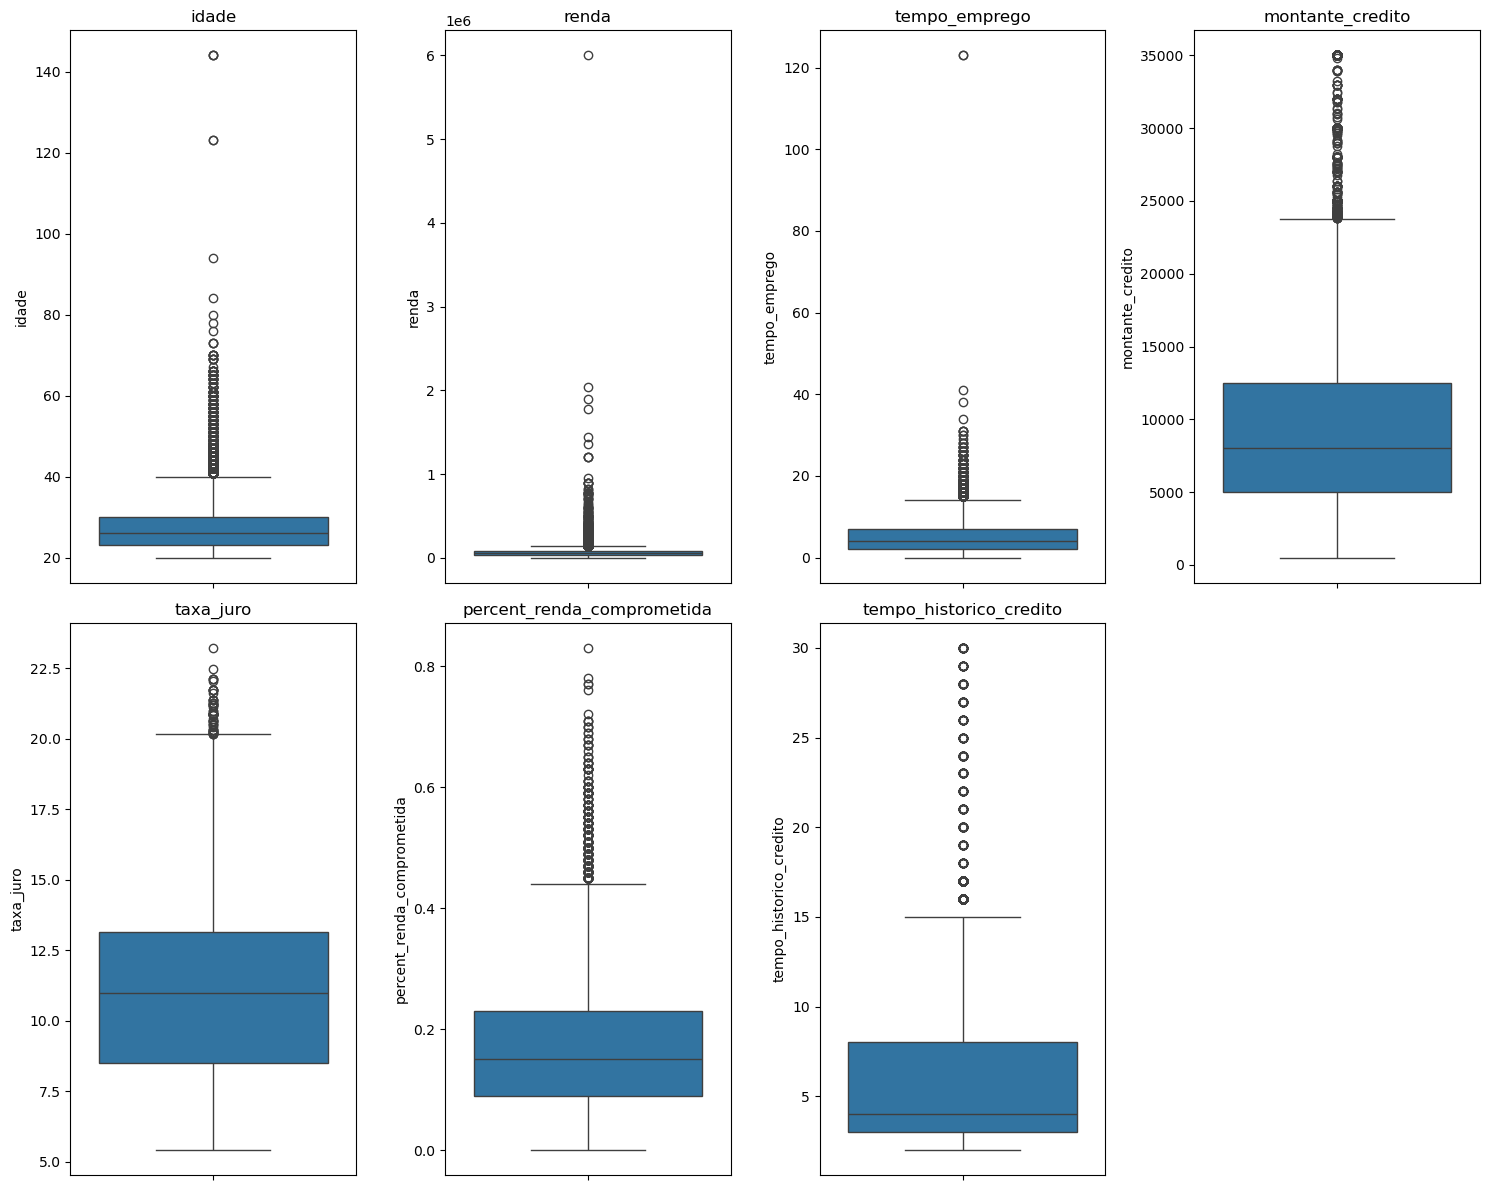

In [23]:
# Análise de Dispesão dos Valores das Variáveis Numéricas por meio de Boxplots

# Configurações de layout
plt.rcParams["figure.figsize"] = [15.00, 12.00]
plt.rcParams["figure.autolayout"] = True

# Criação de subplots com 2 linhas e 4 colunas
fig, axes = plt.subplots(2, 4)

linha, coluna = 0, 0

# Plotagem 
for variavel in variaveis_numericas:
    sns.boxplot(data=df, y=variavel, ax=axes[linha, coluna])
    axes[linha, coluna].set_title(variavel)
    coluna += 1
    if coluna == 4:
        linha += 1
        coluna = 0

# Remoção de subplots vazios 
if len(variaveis_numericas) < 2 * 4:  
    for idx in range(len(variaveis_numericas), 2 * 4):
        fig.delaxes(axes[idx // 4, idx % 4])

# Ajuste do layout e exibição dos gráficos
plt.tight_layout()
plt.show()

Os gráficos (boxplots) mostram que todas as variáveis numéricas possuem _outliers_. Assim sendo, no tratamento de dados ausentes, decidiu-se a exclusão de registros com as seguintes características:

* **idade** acima de 60 anos (69 clientes)
* **renda** acima de 1.000.000,00 unidades monetárias (7 clientes)
* **tempo_emprego** está cima de 35 anos (5 clientes)
* **percent_renda_comprometida** acima de 0.75

In [24]:
# Tratamento de Dados Ausentes

# Exclusão de clientes com "idade" acima de 60 anos (69 clientes)
df = df[df['idade'] <= 60]

# Exlclusão de clientes com "renda" acima de cima de 1.000.000,00 unidades monetárias (7 clientes)
df = df[df['renda'] <= 1000000]

# Exclusão de clientes cujo "tempo_emprego" está cima de 35 anos (5 clientes)
df = df[df['tempo_emprego'] <= 35]

# Exclusão de clientes com percent_renda_comprometida acima de 0.75 (3 clientes)
df = df[df['percent_renda_comprometida'] <= 0.75]

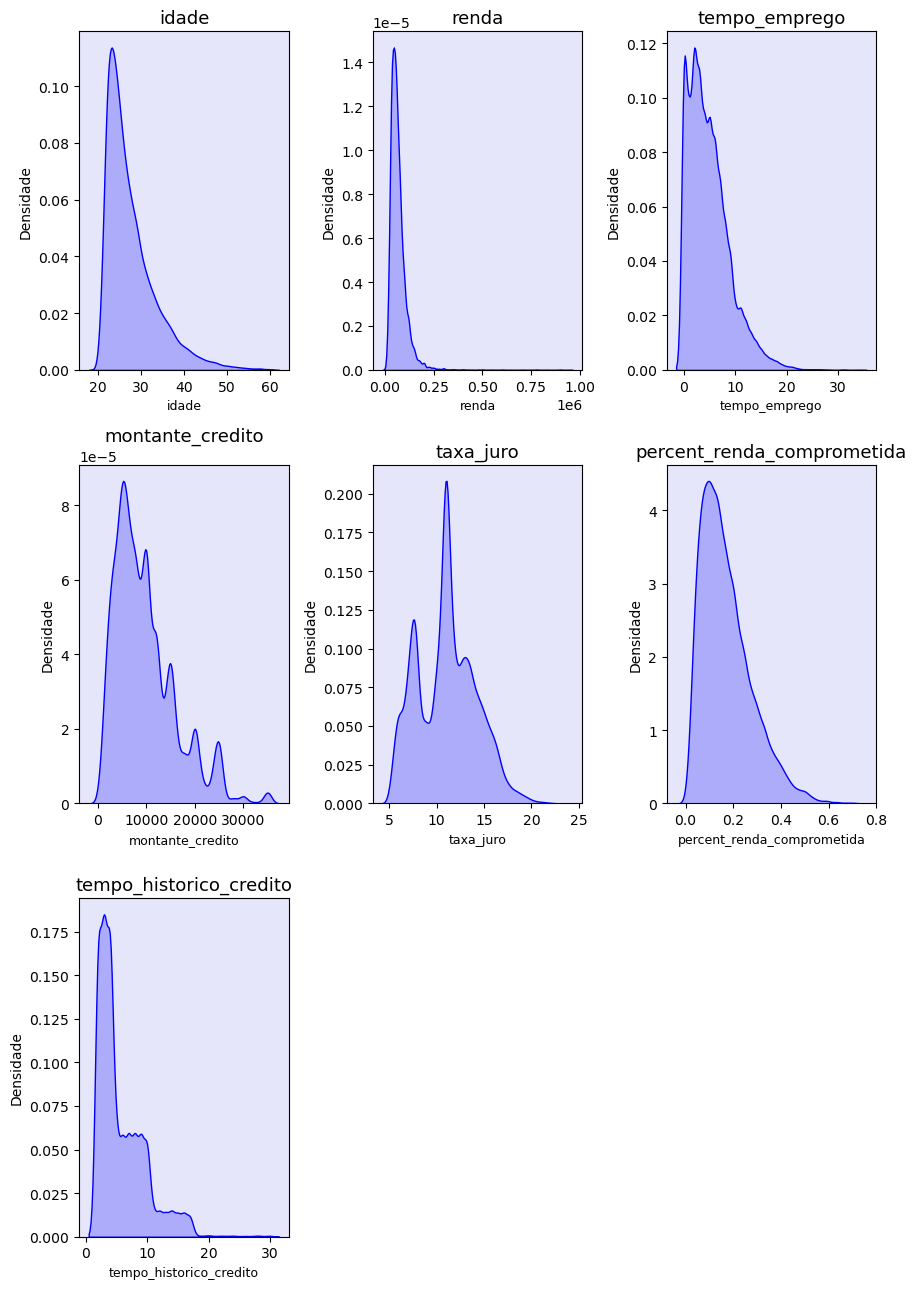

In [56]:
# Gráficos de Densidade das Variáveis Numéricas

# Definição do número de colunas e linhas
numero_linhas = 3
numero_colunas = 3

num_plots = len(variaveis_numericas)

# Configuração do layout
plt.rcParams["figure.figsize"] = [9, 13]
plt.rcParams["figure.autolayout"] = True

# Criação da figura
fig, axes = plt.subplots(numero_linhas, numero_colunas)
axes = axes.flatten()

# Plotagem 
for i, variavel in enumerate(variaveis_numericas):
    sns.kdeplot(data=df[variavel], ax=axes[i], fill=True, color='blue')
    axes[i].set_title(variavel, fontsize=13)
    axes[i].set_xlabel(variavel, fontsize=9)
    axes[i].set_ylabel('Densidade')
    axes[i].set_facecolor('lavender')

# Remoção de eixos não usados
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

# Ajuste do layout
plt.tight_layout()

# Gravação do gráfico no formato SVG
plt.savefig('Grafico_EDA_densidade3.svg', format='svg')

# Exibição do gráfico
plt.show()

##### Análise de correlação entre variáveis 

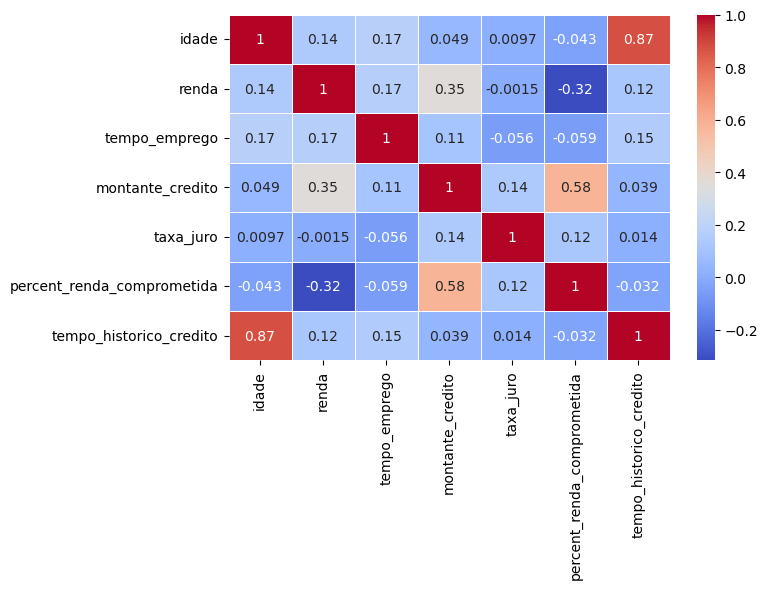

In [27]:
# Criação da matriz de correlação
matriz_correlacao = df[variaveis_numericas].corr()

# Criação do heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', linewidths=0.5)

# Exibição do heatmap
plt.show()

A matriz de correlação mostra a existência de uma correlação forte positiva **(0,87)** entre as variáveis **tempo_historico_credito** e **idade**. 

Diante desta situação, para evitar redundância de informação na modelagem, será removida uma das variáveis, neste caso a variável **tempo_historico_credito**.

In [28]:
# Eliminação da variável 'tempo_historico_credito' 

df_final = df.drop('tempo_historico_credito', axis=1)  

### Análise das variáveis categóricas 

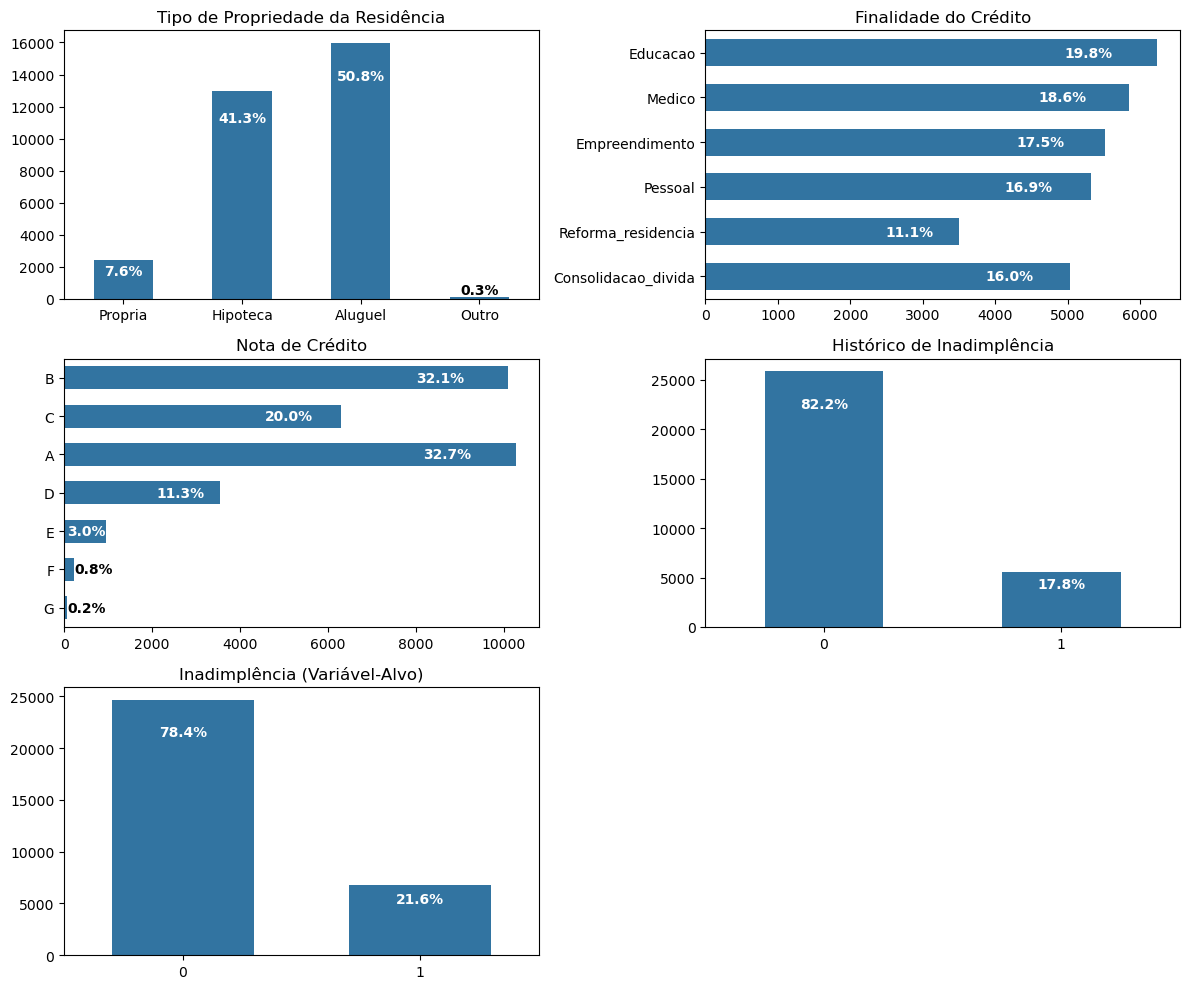

In [52]:
# Configuração da figura 
fig, axes = plt.subplots(3, 2, figsize=(12, 10)) 

# Ajuste do espaço entre os subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Função para adição dos valores percentuais
def add_percentage_labels(ax, horizontal=False):
    total = sum([p.get_width() if horizontal else p.get_height() for p in ax.patches])
    for p in ax.patches:
        percentage = f"{100 * (p.get_width() if horizontal else p.get_height()) / total:.1f}%"
        if horizontal:
            x = p.get_width() - (p.get_width() * 0.1) if p.get_width() > 0.05 * total else p.get_width() + 5
            y = p.get_y() + p.get_height() / 2
            ha = 'right' if p.get_width() > 0.025 * total else 'left'
            ax.text(x, y, percentage, ha=ha, va='center', color='white' if ha == 'right' else 'black', fontsize=10, weight='bold')
        else:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height() - (p.get_height() * 0.1) if p.get_height() > 0.05 * total else p.get_height() + 5
            va = 'top' if p.get_height() > 0.05 * total else 'bottom'
            ax.text(x, y, percentage, ha='center', va=va, color='white' if va == 'top' else 'black', fontsize=10, weight='bold')

# Plotagem para a variável "propriedade_residência"
sns.countplot(data=df, x='propriedade_residencia', width=0.5, ax=axes[0, 0])
axes[0, 0].set_title('Tipo de Propriedade da Residência')
axes[0, 0].set_xlabel('')  
axes[0, 0].set_ylabel('') 
add_percentage_labels(axes[0, 0])

# Plotagem para a variável "finalidade_credito"
sns.countplot(data=df, y='finalidade_credito', width=0.6, ax=axes[0, 1])
axes[0, 1].set_title('Finalidade do Crédito')
axes[0, 1].set_xlabel('')  
axes[0, 1].set_ylabel('')  
add_percentage_labels(axes[0, 1], horizontal=True)

# Plotagem da nota de crédito (barras horizontais)
sns.countplot(data=df, y='nota_credito', width=0.6, ax=axes[1, 0])
axes[1, 0].set_title('Nota de Crédito')
axes[1, 0].set_xlabel('')  
axes[1, 0].set_ylabel('')  
add_percentage_labels(axes[1, 0], horizontal=True)

# Plotagem para a variável "historico_inadimplencia"
sns.countplot(data=df, x='historico_inadimplencia', width=0.5, ax=axes[1, 1])
axes[1, 1].set_title('Histórico de Inadimplência')
axes[1, 1].set_xlabel('')  
axes[1, 1].set_ylabel('') 
add_percentage_labels(axes[1, 1])

# Plotagem para a variável "inadimplencia"
sns.countplot(data=df, x='inadimplencia', width=0.6, ax=axes[2, 0])
axes[2, 0].set_title('Inadimplência (Variável-Alvo)')
axes[2, 0].set_xlabel('') 
axes[2, 0].set_ylabel('')  
add_percentage_labels(axes[2, 0])

# Remoção do subplot vazio
fig.delaxes(axes[2, 1])

# Ajuste do layout e exibição do gráfico
plt.tight_layout()
plt.show()

### Definição das Variáveis Independentes (Preditoras)  e Variável Dependente (Alvo)

In [33]:
# Variáveis Independentes
X_df = df_final.drop('inadimplencia', axis=1)

# Variável Dependente
y_df = df_final['inadimplencia']

### Aplicação do One-Hot Encodig

In [36]:
variaveis_one_hot_encoding = ['propriedade_residencia', 'finalidade_credito', 'nota_credito']

variaveis_restantes = ['idade', 'renda', 'tempo_emprego', 'montante_credito', 'taxa_juro', 
                       'percent_renda_comprometida', 'historico_inadimplencia']

encoder = OneHotEncoder(sparse_output=False, drop=None)
array_encoded = encoder.fit_transform(X_df[variaveis_one_hot_encoding])
X_encoded_categ = pd.DataFrame(array_encoded, columns=encoder.get_feature_names_out(variaveis_one_hot_encoding), index=X_df.index)
X_encoded = pd.concat([X_df[variaveis_restantes], X_encoded_categ], axis=1)

X_encoded.head()

,idade,renda,tempo_emprego,montante_credito,taxa_juro,percent_renda_comprometida,historico_inadimplencia,propriedade_residencia_Aluguel,propriedade_residencia_Hipoteca,propriedade_residencia_Outro,...,finalidade_credito_Medico,finalidade_credito_Pessoal,finalidade_credito_Reforma_residencia,nota_credito_A,nota_credito_B,nota_credito_C,nota_credito_D,nota_credito_E,nota_credito_F,nota_credito_G
1,21,9600,5.0,1000,11.14,0.10,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,25,9600,1.0,5500,12.87,0.57,0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,23,65500,4.0,35000,15.23,0.53,0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,24,54400,8.0,35000,14.27,0.55,1,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,21,9900,2.0,2500,7.14,0.25,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalização dos Valores das Variáveis Independentes

In [37]:
scaler = MinMaxScaler()
X_norm_array = scaler.fit_transform(X_encoded)
X_norm_df = pd.DataFrame(X_norm_array, columns=X_encoded.columns)

X_norm_df.head()

,idade,renda,tempo_emprego,montante_credito,taxa_juro,percent_renda_comprometida,historico_inadimplencia,propriedade_residencia_Aluguel,propriedade_residencia_Hipoteca,propriedade_residencia_Outro,...,finalidade_credito_Medico,finalidade_credito_Pessoal,finalidade_credito_Reforma_residencia,nota_credito_A,nota_credito_B,nota_credito_C,nota_credito_D,nota_credito_E,nota_credito_F,nota_credito_G
0,0.025,0.005932,0.147059,0.014493,0.321348,0.138889,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.125,0.005932,0.029412,0.144928,0.418539,0.791667,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.075,0.065148,0.117647,1.000000,0.551124,0.736111,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.100,0.053390,0.235294,1.000000,0.497191,0.763889,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.025,0.006250,0.058824,0.057971,0.096629,0.347222,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Selecção de Variáveis

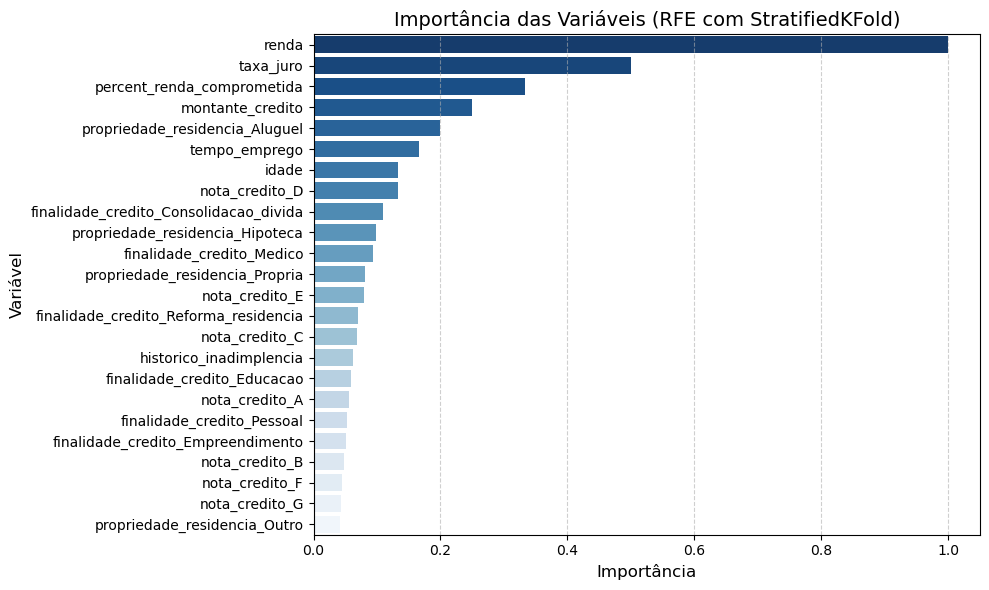

In [39]:
def plot_feature_importance_rfeDD(X, y, model=None, n_splits=10):
    """
    Calcula e plota a importância das variáveis usando RFE com StratifiedKFold.

    Parâmetros:
      X : Conjunto de variáveis independentes (pandas.DataFrame);
      y : Variável dependente (pandas.Series).

      model: estimador do scikit-learn. Se não for informado, fica default = RandomForestClassifier.
        Modelo de aprendizado de máquina usado para avaliação da importância.

      n_splits : numero de dobras para validação cruzada estratificada (StratifiedKFold).
    """
    if model is None:
        model = RandomForestClassifier(random_state=42)

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    ranking_list = []

    for train_idx, test_idx in kf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        rfe = RFE(estimator=model, n_features_to_select=1, step=1)
        rfe.fit(X_train, y_train)
        ranking_list.append(rfe.ranking_)

    # Cálculo da média dos rankings 
    mean_ranking = np.mean(ranking_list, axis=0)
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': 1 / mean_ranking  # Inversão do ranking para que valores menores signifiquem maior importância
    }).sort_values(by='Importance', ascending=False)

    # Criação do gráfico
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'], palette='Blues_r')
    plt.title('Importância das Variáveis (RFE com StratifiedKFold)', fontsize=14)
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Variável', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Chamada da função
plot_feature_importance_rfeDD(X=X_norm_df, y=y_df, model=None, n_splits=10)

O gráfico acima mostra as variáveis mais e menos importantes. Serão **excluídas** as últimas três variáveis menos importantes, nomeadamente:

* **nora_credito_F**;
* **nora_credito_G**; e
* **propriedade_residencia_Outro**.

In [40]:
# Exclusão das variáveis 'nota_credito_G', 'nota_credito_F' e'propriedade_residencia_Outro', 

X_selected_df = X_norm_df.drop(['nota_credito_F','nota_credito_G', 'propriedade_residencia_Outro'], axis=1)
#X_selected_df.to_csv('X_selected_df25.csv', index=False) # Gravação do dataframe
X_selected_df.head()

,idade,renda,tempo_emprego,montante_credito,taxa_juro,percent_renda_comprometida,historico_inadimplencia,propriedade_residencia_Aluguel,propriedade_residencia_Hipoteca,propriedade_residencia_Propria,...,finalidade_credito_Educacao,finalidade_credito_Empreendimento,finalidade_credito_Medico,finalidade_credito_Pessoal,finalidade_credito_Reforma_residencia,nota_credito_A,nota_credito_B,nota_credito_C,nota_credito_D,nota_credito_E
0,0.025,0.005932,0.147059,0.014493,0.321348,0.138889,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.125,0.005932,0.029412,0.144928,0.418539,0.791667,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.075,0.065148,0.117647,1.000000,0.551124,0.736111,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.100,0.053390,0.235294,1.000000,0.497191,0.763889,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.025,0.006250,0.058824,0.057971,0.096629,0.347222,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Modelagem

In [41]:
# Dados para modelagem

X = X_selected_df # Variáveis Independentes (Variáveis preditoras)
y = y_df # Variável Dependente (Variável alvo)

In [159]:

# Inicialização do dicionário para armazenamento dos resultados
resultados_metricas = {
    'RL': {'Acuracia': [], 'Precisao': [], 'Recall': [], 'F1-Score': [], 'AUC-ROC': [], 'KS': []},
    'NB': {'Acuracia': [], 'Precisao': [], 'Recall': [], 'F1-Score': [], 'AUC-ROC': [], 'KS': []},
    'RF': {'Acuracia': [], 'Precisao': [], 'Recall': [], 'F1-Score': [], 'AUC-ROC': [], 'KS': []},
    'XGB': {'Acuracia': [], 'Precisao': [], 'Recall': [], 'F1-Score': [], 'AUC-ROC': [], 'KS': []},
    'RNA': {'Acuracia': [], 'Precisao': [], 'Recall': [], 'F1-Score': [], 'AUC-ROC': [], 'KS': []},
    'SVM': {'Acuracia': [], 'Precisao': [], 'Recall': [], 'F1-Score': [], 'AUC-ROC': [], 'KS': []},
}

# Armazenamento das probabilidades e rótulos reais por modelo
resultados_probabilidades = {nome: [] for nome in ['RL', 'NB', 'RF', 'XGB', 'RNA', 'SVM']}
resultados_reais = {nome: [] for nome in ['RL', 'NB', 'RF', 'XGB', 'RNA', 'SVM']}

n_repeticoes = 30
k_folds = 10

# Modelos
modelos = {
    'RL': LogisticRegression(C=1.0, solver='lbfgs', tol=0.0001, random_state=42),
    'NB': GaussianNB(),
    'RF': RandomForestClassifier(criterion='entropy', min_samples_leaf=1, min_samples_split=5, n_estimators=10, random_state=42),
    'RNA': MLPClassifier(activation='relu', batch_size='auto', solver='adam', random_state=42, max_iter=200),
    'SVM': SVC(kernel='linear', probability=False, random_state=42),  # probability=False para SVM
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
}

# Transformação de y em 1D
y = y.values.ravel()

for repeticao in range(n_repeticoes):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=repeticao)
    
    for nome_modelo, modelo in modelos.items():
        # Listas para o armazenamento das métricas de cada dobra (fold)
        Acuracias_folds = []
        Precisoes_folds = []
        Recalls_folds = []
        F1_Scores_folds = []
        AUC_ROCs_folds = []
        KS_stats_folds = []
        
        for fold, (indices_treino, indices_teste) in enumerate(skf.split(X, y)):
            
            X_treino, X_teste = X.iloc[indices_treino], X.iloc[indices_teste]
            y_treino, y_teste = y[indices_treino], y[indices_teste] 
            
            # Calibração para o SVM (Para minimização do tempo de treinamento)
            if nome_modelo == 'SVM':
                base_model = SVC(kernel='linear', probability=False, random_state=42)
                base_model.fit(X_treino, y_treino)  
                modelo = CalibratedClassifierCV(base_model, method='sigmoid', cv='prefit')
                modelo.fit(X_treino, y_treino)
            else:
                # Treinamento do modelo
                modelo.fit(X_treino, y_treino)
            
            # Previsões e probabilidades
            y_pred = modelo.predict(X_teste)
            y_prob = modelo.predict_proba(X_teste)[:, 1]  
            
            # Armazenamento de probabilidades e rótulos reais
            resultados_probabilidades[nome_modelo].append(y_prob)
            resultados_reais[nome_modelo].append(y_teste)
            
            # Cálculo das métricas
            Acuracias_folds.append(accuracy_score(y_teste, y_pred))
            Precisoes_folds.append(precision_score(y_teste, y_pred))
            Recalls_folds.append(recall_score(y_teste, y_pred))
            F1_Scores_folds.append(f1_score(y_teste, y_pred))
            AUC_ROCs_folds.append(roc_auc_score(y_teste, y_prob))
            
            # Cálculo da estatística KS
            ks_stat, _ = ks_2samp(y_prob[y_teste == 1], y_prob[y_teste == 0])  # Comparar as distribuições
            KS_stats_folds.append(ks_stat)
        
        # Armazenamento das médias das métricas da repetição
        resultados_metricas[nome_modelo]['Acuracia'].append(np.mean(Acuracias_folds))
        resultados_metricas[nome_modelo]['Precisao'].append(np.mean(Precisoes_folds))
        resultados_metricas[nome_modelo]['Recall'].append(np.mean(Recalls_folds))
        resultados_metricas[nome_modelo]['F1-Score'].append(np.mean(F1_Scores_folds))
        resultados_metricas[nome_modelo]['AUC-ROC'].append(np.mean(AUC_ROCs_folds))
        resultados_metricas[nome_modelo]['KS'].append(np.mean(KS_stats_folds))

# Exibição dos resultados
for nome_modelo, metricas in resultados_metricas.items():
    print(f'Resultados do modelo {nome_modelo}:')
    for metrica, valores in metricas.items():
        print(f'{metrica}: Média = {np.mean(valores):.4f} Desvio padrão: {np.std(valores):.4f}')
    print(f"{'-'*28}")



Resultados do modelo RL:
Acuracia: Média = 0.8666 Desvio padrão: 0.0002
Precisao: Média = 0.7655 Desvio padrão: 0.0008
Recall: Média = 0.5508 Desvio padrão: 0.0007
F1-Score: Média = 0.6404 Desvio padrão: 0.0006
AUC-ROC: Média = 0.8701 Desvio padrão: 0.0001
KS: Média = 0.6147 Desvio padrão: 0.0005
----------------------------
Resultados do modelo NB:
Acuracia: Média = 0.8276 Desvio padrão: 0.0002
Precisao: Média = 0.5950 Desvio padrão: 0.0006
Recall: Média = 0.6309 Desvio padrão: 0.0004
F1-Score: Média = 0.6123 Desvio padrão: 0.0004
AUC-ROC: Média = 0.8378 Desvio padrão: 0.0001
KS: Média = 0.5474 Desvio padrão: 0.0007
----------------------------
Resultados do modelo RF:
Acuracia: Média = 0.9309 Desvio padrão: 0.0005
Precisao: Média = 0.9536 Desvio padrão: 0.0024
Recall: Média = 0.7148 Desvio padrão: 0.0014
F1-Score: Média = 0.8170 Desvio padrão: 0.0012
AUC-ROC: Média = 0.9180 Desvio padrão: 0.0012
KS: Média = 0.7253 Desvio padrão: 0.0020
----------------------------
Resultados do mode

/home/dionisio/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:43:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [69]:
resultados_metricas_df = pd.DataFrame.from_dict({(i, j): resultados_metricas[i][j] for i in resultados_metricas.keys() for j in resultados_metricas[i].keys()}).T
resultados_metricas_df.index.names = ['modelo', 'metrica']
resultados_metricas_df.to_csv('metrics_results_df_final.csv', index=True)

In [70]:
resultados_metricas_df

0         1         2         3         4         5   \
modelo metrica                                                                
RL     Acuracia  0.866720  0.866561  0.866274  0.866275  0.866751  0.866561   
       Precisao  0.766010  0.765624  0.764344  0.764471  0.767544  0.765128   
       Recall    0.550836  0.550395  0.550101  0.549664  0.550250  0.550981   
       F1-Score  0.640625  0.640226  0.639605  0.639463  0.640513  0.640323   
       AUC-ROC   0.870020  0.870063  0.870202  0.870054  0.869998  0.870083   
       KS        0.614995  0.614973  0.615006  0.615498  0.614553  0.614409   
NB     Acuracia  0.827381  0.827572  0.827508  0.827731  0.827985  0.827731   
       Precisao  0.594387  0.594858  0.594813  0.595178  0.596490  0.595154   
       Recall    0.630412  0.630708  0.630409  0.630716  0.630271  0.631301   
       F1-Score  0.611701  0.612198  0.612004  0.612349  0.612662  0.612526   
       AUC-ROC   0.837803  0.837947  0.837780  0.837712  0.837797  0.837783   
       KS        0.547552  0.547115  0.547647  0.547781  0.547578  0.547910   
RF     Acuracia  0.930577  0.930513  0.931308  0.930991  0.930609  0.931118   
       Precisao  0.952995  0.951189  0.954808  0.954391  0.952418  0.951121   
       Recall    0.713523  0.714844  0.715585  0.714411  0.714267  0.717804   
       F1-Score  0.816021  0.816044  0.818000  0.817086  0.816198  0.818012   
       AUC-ROC   0.916924  0.917913  0.919061  0.916540  0.918299  0.916123   
       KS        0.726517  0.723468  0.725895  0.726036  0.722446  0.727818   
XGB    Acuracia  0.935474  0.936429  0.935665  0.935252  0.936079  0.935475   
       Precisao  0.953418  0.957783  0.955259  0.950227  0.955173  0.956094   
       Recall    0.737102  0.737984  0.736365  0.738729  0.738437  0.734895   
       F1-Score  0.831363  0.833553  0.831623  0.831179  0.832838  0.830851   
       AUC-ROC   0.951291  0.950638  0.951194  0.950338  0.950610  0.950227   
       KS        0.768278  0.766884  0.764110  0.769374  0.765771  0.766382   
RNA    Acuracia  0.924376  0.924916  0.925393  0.925680  0.925362  0.924758   
       Precisao  0.932342  0.935856  0.938384  0.936910  0.937753  0.936377   
       Recall    0.700704  0.700255  0.700405  0.703214  0.701004  0.698941   
       F1-Score  0.799948  0.800882  0.801968  0.803174  0.802081  0.800269   
       AUC-ROC   0.920146  0.920284  0.920390  0.920695  0.919051  0.920423   
       KS        0.701496  0.706904  0.705228  0.707369  0.705498  0.704628   
SVM    Acuracia  0.867324  0.867324  0.867387  0.867324  0.866910  0.867451   
       Precisao  0.766755  0.766199  0.766511  0.766195  0.765674  0.767224   
       Recall    0.553783  0.554962  0.554523  0.554524  0.553343  0.554223   
       F1-Score  0.642950  0.643499  0.643415  0.643299  0.642162  0.643224   
       AUC-ROC   0.866151  0.866244  0.866398  0.866246  0.866273  0.866280   
       KS        0.615354  0.615317  0.615342  0.614883  0.615683  0.615860   

                       6         7         8         9   ...        20  \
modelo metrica                                           ...             
RL     Acuracia  0.866211  0.866465  0.866561  0.866752  ...  0.866688   
       Precisao  0.764812  0.764552  0.764603  0.767175  ...  0.765750   
       Recall    0.549664  0.550987  0.551725  0.549959  ...  0.550992   
       F1-Score  0.639404  0.640232  0.640896  0.640339  ...  0.640656   
       AUC-ROC   0.870089  0.870115  0.870100  0.870035  ...  0.870124   
       KS        0.614218  0.614632  0.614467  0.615542  ...  0.615125   
NB     Acuracia  0.827413  0.827699  0.827413  0.827699  ...  0.827540   
       Precisao  0.594631  0.595012  0.594458  0.595483  ...  0.594847   
       Recall    0.630711  0.630853  0.630864  0.630716  ...  0.631447   
       F1-Score  0.611997  0.612252  0.612050  0.612375  ...  0.612452   
       AUC-ROC   0.837910  0.837968  0.837861  0.837703  ...  0.838046   
       KS        0.547710  0.547429  0.546298  0.549830  .

### Tabela do Desempenho Geral

In [71]:

# Carregamento os dados (substitua pelo método de importação correto, como pd.read_csv ou pd.read_excel)
df = pd.read_csv('metrics_results_df_final.csv')

# Cálculo das médias por modelo e por métrica
df_media = df.iloc[:, 2:].mean(axis=1) 
df['Media'] = df_media 

desemp_geral_df = df.pivot_table(index='metrica', columns='modelo', values='Media')
desemp_geral_df

modelo,NB,RF,RL,RNA,SVM,XGB
metrica,,,,,,
AUC-ROC,0.837847,0.917966,0.870089,0.919969,0.866297,0.950668
Acuracia,0.827606,0.930928,0.866591,0.925253,0.867285,0.935657
F1-Score,0.612265,0.816971,0.640403,0.801671,0.642908,0.831740
KS,0.547372,0.725297,0.614685,0.704908,0.615711,0.766380
Precisao,0.594976,0.953624,0.765463,0.937693,0.766554,0.954112
Recall,0.630859,0.714781,0.550762,0.700438,0.553896,0.737371


### Apresentação gráfica dos Resultados da Acurácia, Precisão, Recall e F1-Score

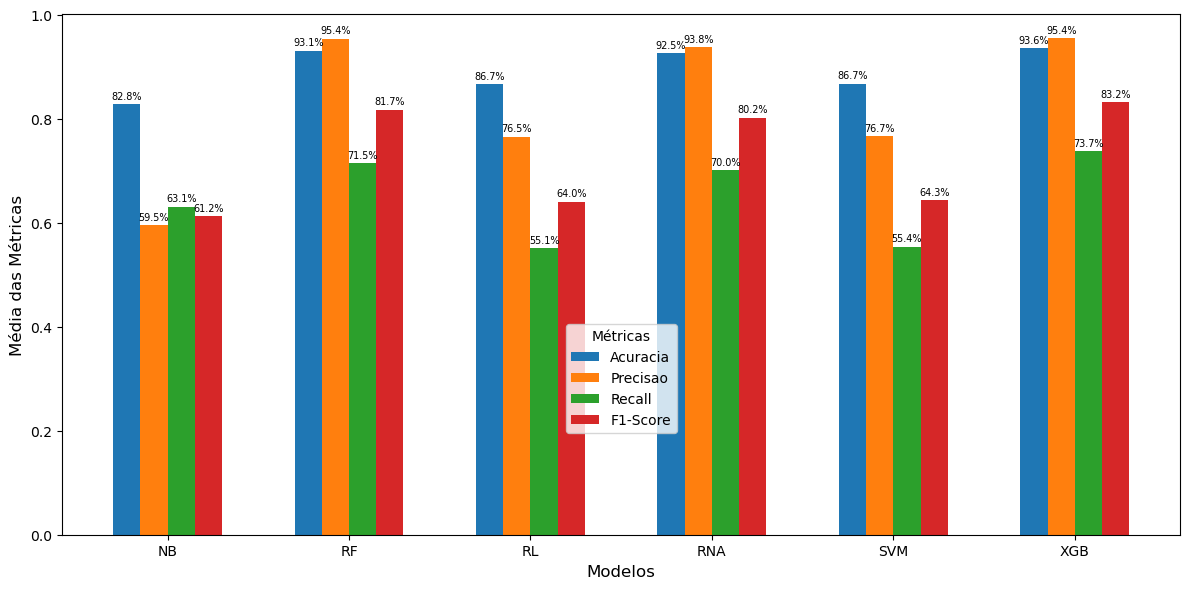

In [165]:
# Configurações do gráfico
modelos = desemp_geral_df.columns.str.upper()  
metricas = desemp_geral_df.index  
x = np.arange(len(modelos)) 
width = 0.15  
fig, ax = plt.subplots(figsize=(12, 6))

# Plotagem
metricas = ['Acuracia', 'Precisao', 'Recall', 'F1-Score'] 
for i, metrica in enumerate(metricas):
    ax.bar(x + i * width, desemp_geral_df.loc[metrica], width, label=metrica)
    # Adicionando valores no topo das barras
    for j, value in enumerate(desemp_geral_df.loc[metrica]):
        ax.text(x[j] + i * width, value + 0.01, f'{value*100:.1f}%', ha='center', fontsize=7)

# Configurações dos eixos e título
ax.set_xticks(x + width * (len(metricas) - 1) / 2)
ax.set_xticklabels(modelos)
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Média das Métricas', fontsize=12)
ax.legend(title='Métricas', loc='center', bbox_to_anchor=(0.5, 0.3))

# Ajuste do layout e exibição do gráfico
plt.tight_layout()
plt.show()


### Resultados da Área sob Curva ROC por Modelo

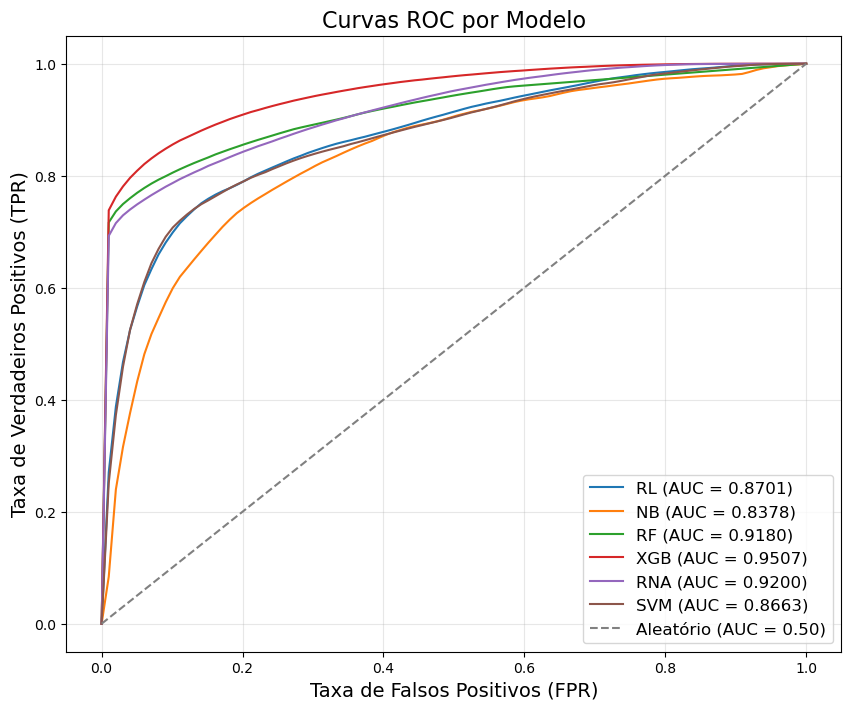

In [75]:
def plotar_curvas_roc(resultados_probabilidades, resultados_reais, resultados_metricas):
    """
    Plota as curvas ROC para todos os modelos.

    Parâmetros:
        resultados_probabilidades: Probabilidades previstas para cada modelo e dobra (dicionário).
        resultados_reais: Rótulos reais correspondentes para cada modelo e dobra (dicionário).
        resultados_metricas: Resultados das métricas calculadas no código principal (dicionário).
    """
    
    plt.figure(figsize=(10, 8))
    
    for nome_modelo, probabilidades in resultados_probabilidades.items():
        tprs = []  
        mean_fpr = np.linspace(0, 1, 100)  

        for i in range(len(probabilidades)):
            y_prob = probabilidades[i]
            y_test = resultados_reais[nome_modelo][i]

            # Cálculo da ROC
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolação
            tprs[-1][0] = 0.0  # Garante que o início seja 0
        
        # Cálculo da média das curvas ROC
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0  # Garante que o fim seja 1
        
        # AUC média calculada no código principal
        mean_auc = np.mean(resultados_metricas[nome_modelo]['AUC-ROC'])
                
        plt.plot(
            mean_fpr,
            mean_tpr,
            label=f'{nome_modelo} (AUC = {mean_auc:.4f})'
        )
    
    # Configurações do gráfico
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório (AUC = 0.50)')
    plt.title('Curvas ROC por Modelo', fontsize=16)
    plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=14)
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()


# Chamada da função
plotar_curvas_roc(resultados_probabilidades, resultados_reais, resultados_metricas)

### Teste de KS (Kolmogorov-Smirnov)

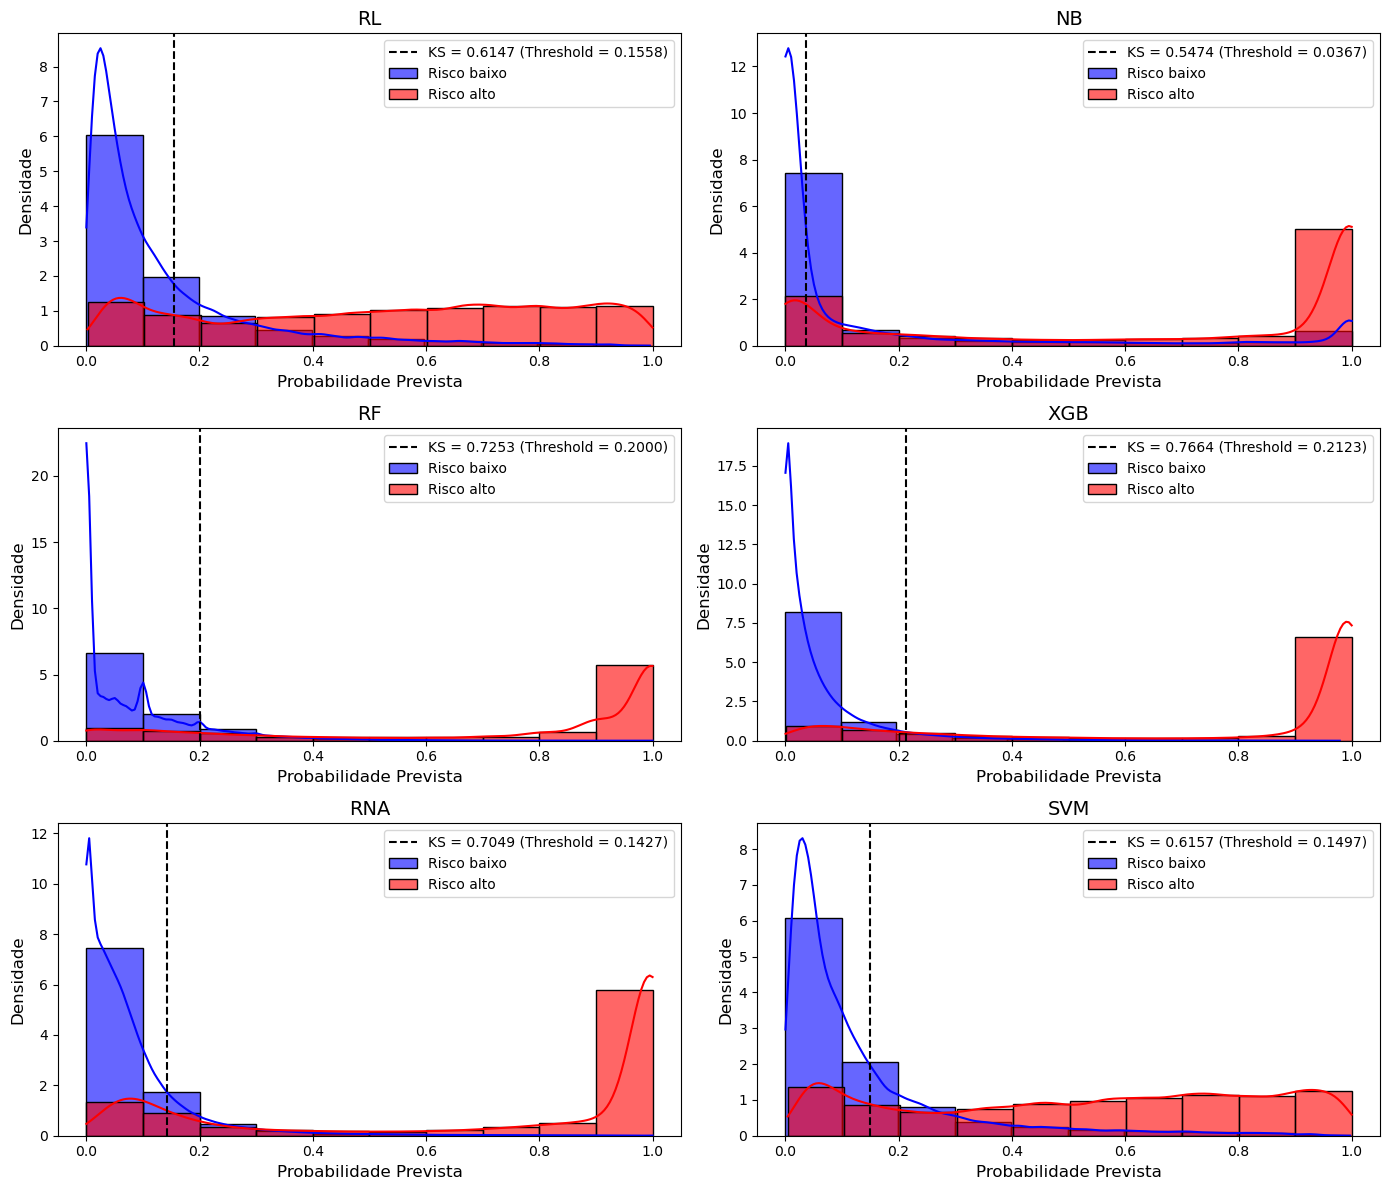

In [97]:
def plotar_distribuicao_ks_subplots(resultados_probabilidades, resultados_reais, resultados_metricas):
    """
    Plota a distribuição das probabilidades previstas para cada modelo, mostrando a separação 
    entre as classes e o ponto de corte (threshold) óptimo baseado no KS.

    Parâmetros:
        resultados_probabilidades: Probabilidades previstas por modelo (dicionário).
        resultados_reais: Rótulos verdadeiros por modelo (dicionário).
        resultados_metricas: Métricas calculadas para cada modelo (dicionário).
    """
    
    modelos = list(resultados_probabilidades.keys())
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.ravel()  

    for i, nome_modelo in enumerate(modelos):
        y_prob = np.concatenate(resultados_probabilidades[nome_modelo])
        y_real = np.concatenate(resultados_reais[nome_modelo])

        ks_stat = np.mean(resultados_metricas[nome_modelo]['KS'])  
        best_threshold = np.percentile(y_prob, ks_stat * 100)
        
        ax = axes[i]
        sns.histplot(y_prob[y_real == 0], color='blue', label='Risco baixo', kde=True, stat="density", bins=10, alpha=0.6, ax=ax)
        sns.histplot(y_prob[y_real == 1], color='red', label='Risco alto', kde=True, stat="density", bins=10, alpha=0.6, ax=ax)

        # Adição da linha do threshold
        ax.axvline(best_threshold, color='black', linestyle='--', label=f'KS = {ks_stat:.4f} (Threshold = {best_threshold:.4f})')

        # Configuração do gráfico
        ax.set_title(f'{nome_modelo}', fontsize=14)
        ax.set_xlabel('Probabilidade Prevista', fontsize=12)
        ax.set_ylabel('Densidade', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(alpha=0.0)

    # Ajuste do layout e exibição do gráfico
    plt.tight_layout()
    plt.show()

# Chamada da função
plotar_distribuicao_ks_subplots(resultados_probabilidades, resultados_reais, resultados_metricas)

### Análise da Dispersão dos Valores das Métricas de Desempenho

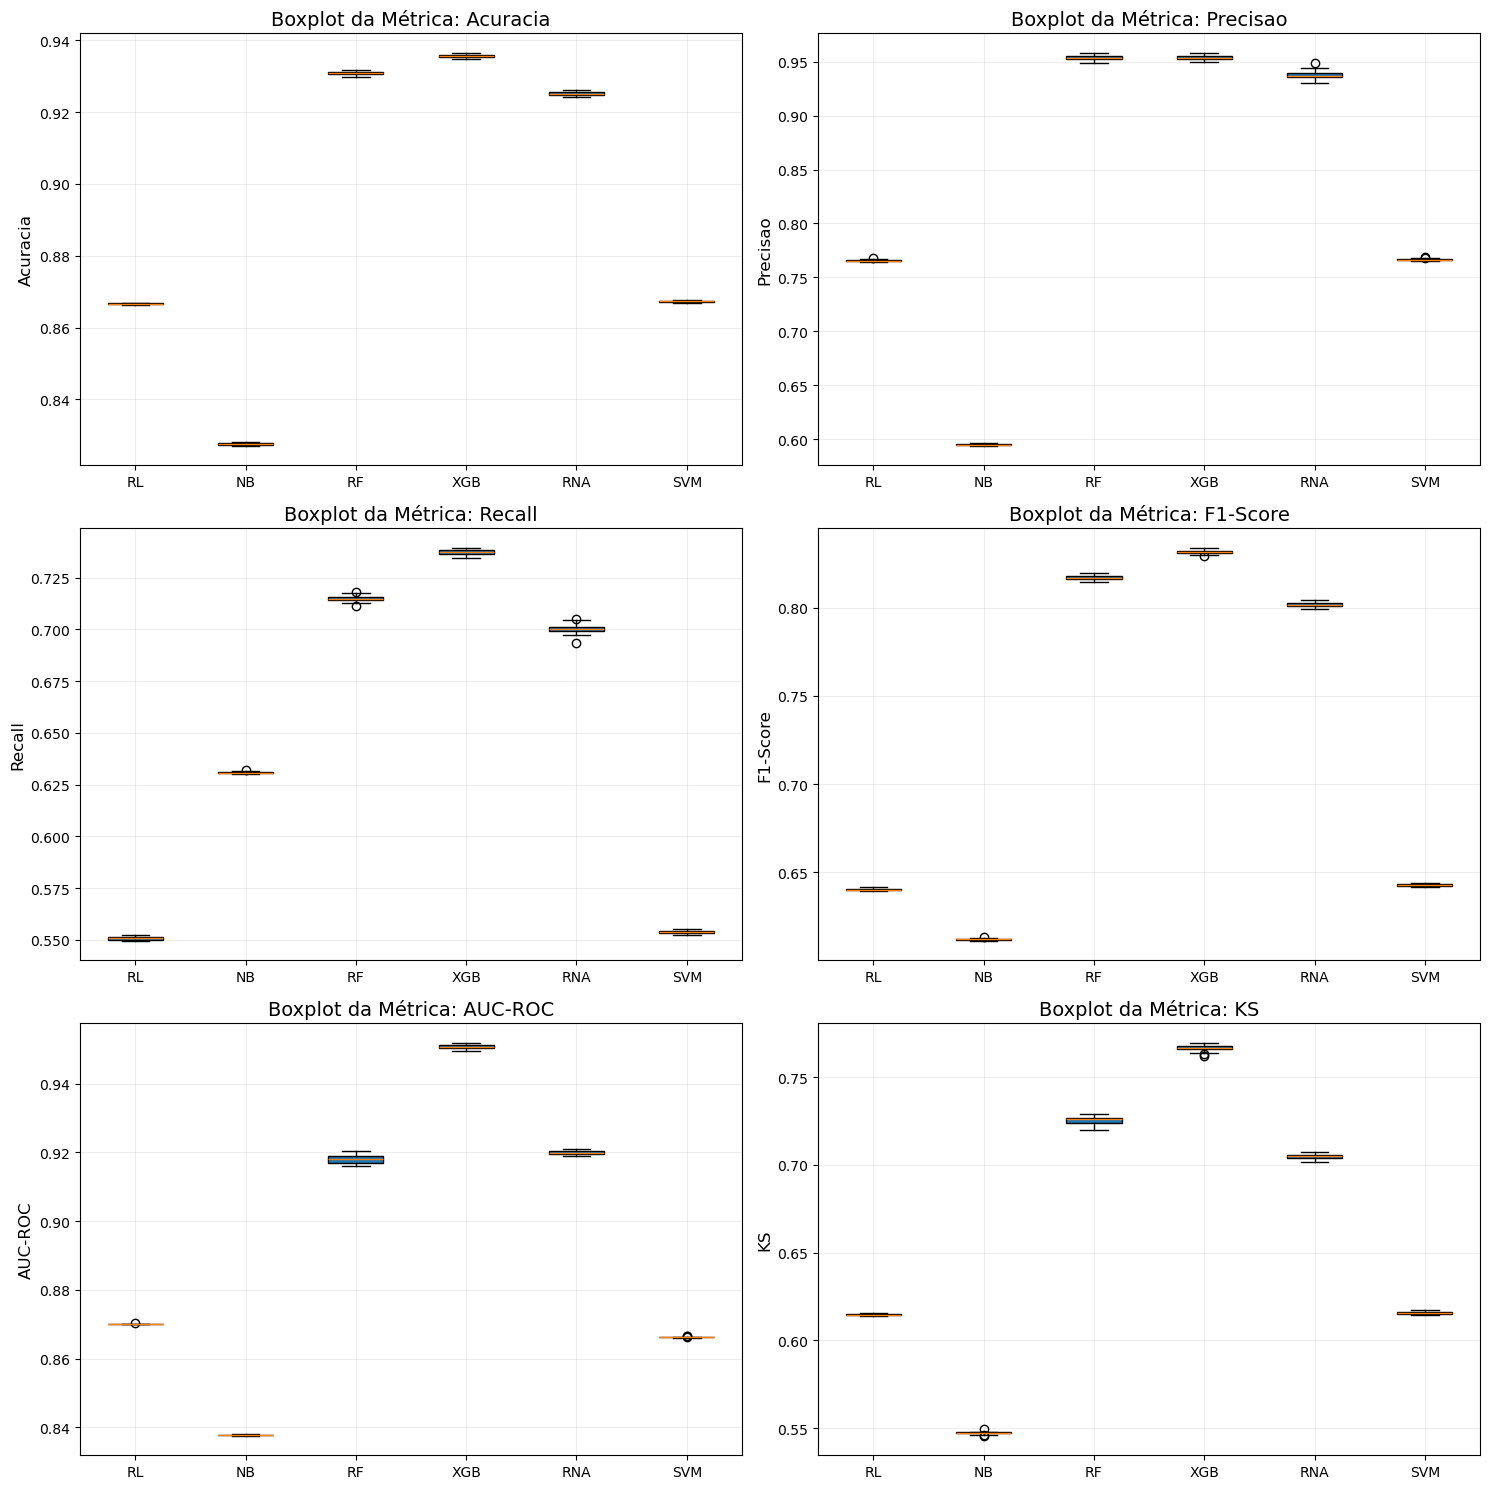

In [74]:
def plotar_boxplots_metricas_subplots(resultados_metricas):
    """
    Plota boxplots para cada métrica: Acurácia, Precisão, Recall, F1-Score, AUC-ROC e KS

    Parâmetros:
    - resultados_metricas: Dicionário contendo as métricas calculadas para cada modelo (dicionário).
    """
    
    metricas = ['Acuracia', 'Precisao', 'Recall', 'F1-Score', 'AUC-ROC', 'KS']
   
    # Configurações da figura
    n_rows, n_cols = 3, 2  
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    axes = axes.ravel() 

    # Plotagem
    for i, metrica in enumerate(metricas):
        dados = {modelo: valores[metrica] for modelo, valores in resultados_metricas.items()}
        ax = axes[i]
        ax.boxplot(dados.values(), labels=dados.keys(), patch_artist=True)
        ax.set_title(f'Boxplot da Métrica: {metrica}', fontsize=14)
        ax.set_ylabel(metrica, fontsize=12)
        ax.grid(alpha=0.22)

    # Remoção de eixos extras
    for i in range(len(metricas), len(axes)):
        fig.delaxes(axes[i])

    # Ajuste do layout e exibição dos gráficos
    plt.tight_layout()
    plt.show()

# Chamada da função
plotar_boxplots_metricas_subplots(resultados_metricas)

### Comparação entre Modelos através da AUC-ROC

In [48]:
# Extração dos Valores da AUC-ROC por Modelo

# Filtragem das linhas referentes à métrica AUC-ROC
auc_roc_df = resultados_metricas_df[resultados_metricas_df["metrica"] == "AUC-ROC"].drop(columns=["metrica"])
auc_roc_df = auc_roc_df.set_index('modelo').T
auc_roc_df

,RL,NB,RF,XGB,RNA,SVM
0,0.870020,0.837803,0.916924,0.951291,0.920146,0.866151
1,0.870063,0.837947,0.917913,0.950638,0.920284,0.866244
2,0.870202,0.837780,0.919061,0.951194,0.920390,0.866398
3,0.870054,0.837712,0.916540,0.950338,0.920695,0.866246
4,0.869998,0.837797,0.918299,0.950610,0.919051,0.866273
5,0.870083,0.837783,0.916123,0.950227,0.920423,0.866280
6,0.870089,0.837910,0.917032,0.950411,0.919364,0.866277
7,0.870115,0.837968,0.918951,0.950424,0.919424,0.866359
8,0.870100,0.837861,0.917470,0.951045,0.919616,0.866313
9,0.870035,0.837703,0.918779,0.951823,0.919691,0.866239


### Teste de Normalidade - Shapiro-Wilk

In [157]:

modelos = auc_roc_df.columns.tolist()
for modelo in modelos:
    stat, p = shapiro(auc_roc_df[modelo])
    print(f'{modelo}: Estatística: {stat}, p-value: {p}')

RL: Estatística: 0.9336442127278268, p-value: 0.061407477357836686
NB: Estatística: 0.9780555589900033, p-value: 0.7718325978767974
RF: Estatística: 0.9389061080191212, p-value: 0.0849955238041913
XGB: Estatística: 0.9479478481918662, p-value: 0.14892487010844668
RNA: Estatística: 0.9806411221802294, p-value: 0.8423371829361468
SVM: Estatística: 0.9208823303411503, p-value: 0.028274091007096495


O modelo (SVM) possui valor-p ≤ 0,05, mostrando que os dados de pelo menos um dos modelos não seguem uma distribuição normal.

### Teste de Homocedasticidade - Levene

In [49]:
from scipy.stats import levene

# Teste de Levene
stat, p_value = levene(
                auc_roc_df['RL'],
                auc_roc_df['NB'],
                auc_roc_df['RF'],
                auc_roc_df['XGB'],
                auc_roc_df['RNA'],
                auc_roc_df['SVM'])

# Resultados
print("Estatística de Levene:", stat)
print("Valor-p:", p_value)

# Interpretação
if p_value > 0.05:
    print("\nNão há evidências de que as variâncias sejam diferentes (Homocedasticidade assumida).")
else:
    print("\nAs variâncias são significativamente diferentes (Homocedasticidade não assumida).")


Estatística de Levene: 39.22089824950882
Valor-p: 7.435209749364229e-27

As variâncias são significativamente diferentes (Homocedasticidade não assumida).


### Teste de Friedman

In [50]:
auc_roc_array = np.array(auc_roc_df)

stat, p = friedmanchisquare(*auc_roc_array.T)
print(f"Estatística de Friedman: {stat}, p-valor: {p}")

if p < 0.05:
    print("\nHá diferença significativa entre os modelos.")
else:
    print("\nNão há diferença significativa entre os modelos.")

Estatística de Friedman: 149.44761904761913, p-valor: 1.7502602018540038e-30

Há diferença significativa entre os modelos.


### Teste de Nemenyi

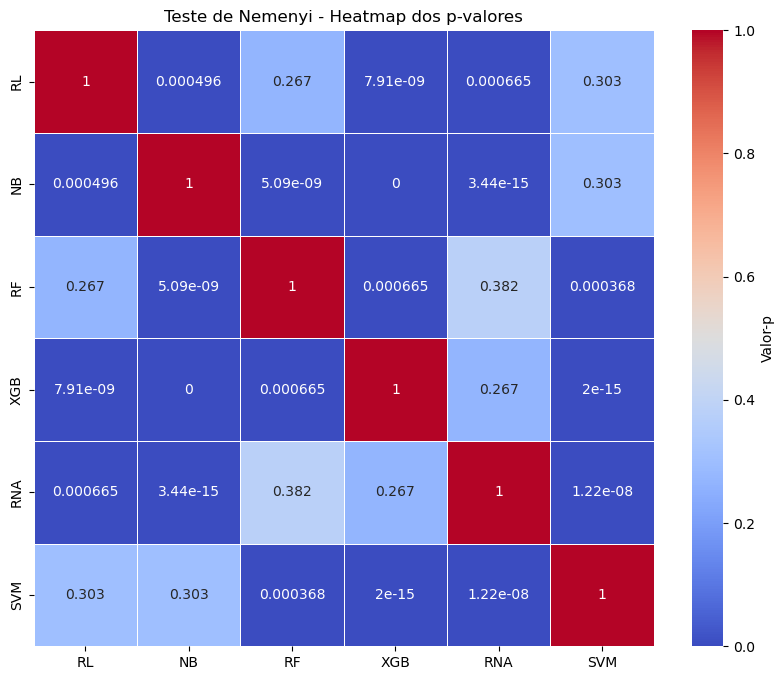

In [152]:
posthoc_df = posthoc_nemenyi_friedman(auc_roc_df)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(posthoc_df, annot=True, fmt=".3g", cmap="coolwarm", linewidths=0.5, xticklabels=posthoc_df.columns, yticklabels=posthoc_df.index, cbar_kws={'label': 'Valor-p'})
plt.title("Teste de Nemenyi - Heatmap dos p-valores")
plt.show()

### Análise SHAP

 96%|=================== | 3011/3144 [00:11<00:00]       


Métricas XGBoost (Cross-Validation):
    Métrica     Média  Desvio Padrão
0  Acurácia  0.935657       0.003805
1  Precisão  0.954112       0.009028
2    Recall  0.737371       0.016424
3  F1-Score  0.831740       0.011195
4   AUC-ROC  0.950668       0.004818
5        KS  0.766380       0.014127


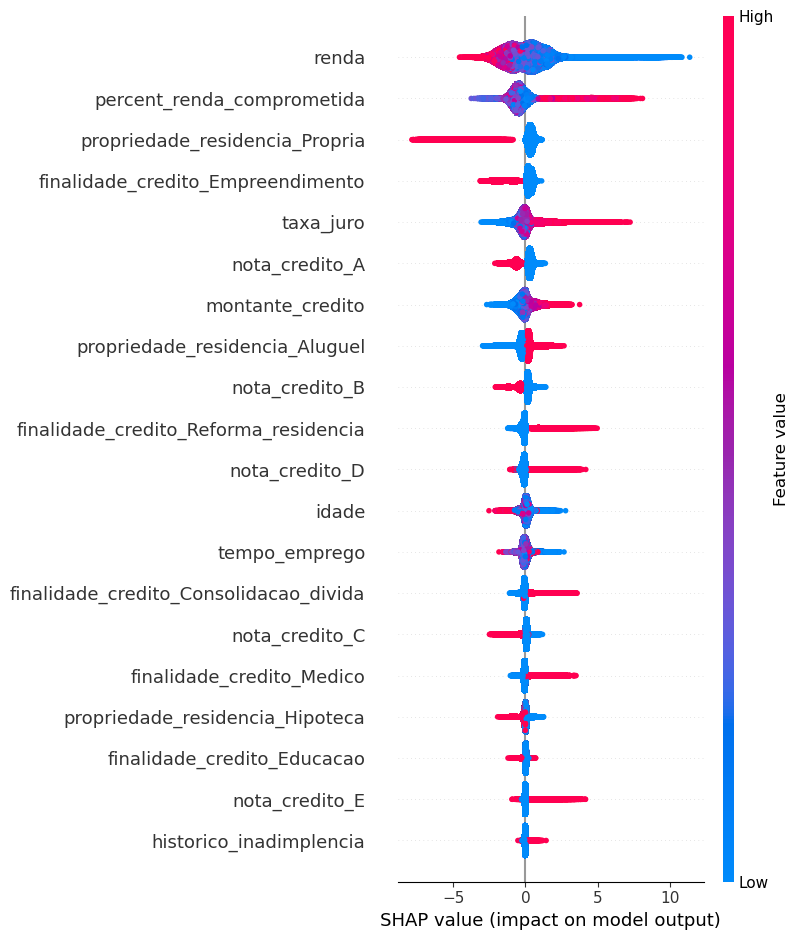

In [45]:
def shap_validacao_cruzada_xgb(X, y, k_folds=10, n_repeticoes=30):
    """
    Realiza análise SHAP utilizando validação cruzada estratificada com XGBoost.
    
    Parâmetros:
        X: Variáveis Indpendentes (pandas.DataFrame)
        y: Rótulos do conjunto de dados (pandas.Series).
        k_folds: Número (inteiro) de dobras (folds) para validação cruzada estratificada.
        n_repeticoes: Número (inteiro) de repetições da validação cruzada.
    """
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from scipy.stats import ks_2samp

    # Configuração do y para garantir que seja uma Series
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    # Inicialização dos resultados
    resultados_metricas = {
        "Acuracia": [], "Precisao": [], "Recall": [], "F1-Score": [], "AUC-ROC": [], "KS": []
    }
    
    shap_values_all = []  
    X_teste_all = []      
    feature_importances = np.zeros(X.shape[1])  

    # Validação Cruzada Estratificada
    for repeticao in range(n_repeticoes):
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=repeticao)

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            X_treino, X_teste = X.iloc[train_idx], X.iloc[test_idx]
            y_treino, y_teste = y.iloc[train_idx], y.iloc[test_idx]

            # Instaciação do modelo XGBoost (modelo selecionado)
            modelo_xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
            modelo_xgb.fit(X_treino, y_treino)

            # Previsões
            y_prob = modelo_xgb.predict_proba(X_teste)[:, 1]
            y_pred = (y_prob > 0.5).astype(int)

            # Cálculo das métricas
            resultados_metricas["Acuracia"].append(accuracy_score(y_teste, y_pred))
            resultados_metricas["Precisao"].append(precision_score(y_teste, y_pred))
            resultados_metricas["Recall"].append(recall_score(y_teste, y_pred))
            resultados_metricas["F1-Score"].append(f1_score(y_teste, y_pred))
            resultados_metricas["AUC-ROC"].append(roc_auc_score(y_teste, y_prob))
            ks_stat, _ = ks_2samp(y_prob[y_teste == 1], y_prob[y_teste == 0])
            resultados_metricas["KS"].append(ks_stat)

            # Análise SHAP para a dodra (fold)
            explainer = shap.Explainer(modelo_xgb, X_treino)
            shap_values = explainer(X_teste)

            # Acumulação dos valores SHAP e dos dados de teste
            shap_values_all.append(shap_values.values)
            X_teste_all.append(X_teste)

            # Acumulação da importância das variáveis independentes
            feature_importances += np.abs(shap_values.values).mean(axis=0)

    # Unificação dos dados de teste e dos valores SHAP
    shap_values_all = np.concatenate(shap_values_all, axis=0)  
    X_teste_all = pd.concat(X_teste_all, axis=0)  

    # Criação do DataFrame com métricas médias
    df_metricas = pd.DataFrame({
        "Métrica": ["Acurácia", "Precisão", "Recall", "F1-Score", "AUC-ROC", "KS"],
        "Média": [np.mean(resultados_metricas[m]) for m in resultados_metricas.keys()],
        "Desvio Padrão": [np.std(resultados_metricas[m]) for m in resultados_metricas.keys()]
    })

    # Exibição das métricas
    print("\nMétricas XGBoost (Cross-Validation):")
    print(df_metricas)

    # Gráfico de Importância das Variáveis Independentes
    feature_importances /= (k_folds * n_repeticoes)  

    return shap.summary_plot(shap_values_all, X_teste_all)

# Chamada da função
shap_validacao_cruzada_xgb(X, y, k_folds=10, n_repeticoes=30)